In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback, EarlyStopping

import pickle
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/comment')
from keras.layers import Embedding, Conv1D, Dropout, Dense, SpatialDropout1D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D
from keras import optimizers, metrics, Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Concatenate, Input, Flatten
from keras.utils import plot_model
from sklearn.metrics import roc_curve,auc,roc_auc_score
from keras.callbacks import Callback
from keras import initializers
from keras.layers import CuDNNGRU
from tqdm import tqdm
import io

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

# 文字处理库
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
nltk.download('stopwords') #下载停止词
import string
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
print('正在加载词向量......')
fin = io.open('crawl-300d-2M.vec', 'r', encoding='utf-8')
embeddings = {} #词向量字典
word_features = 0 #词向量维度
for line in tqdm(fin):
    tokens =  line.rstrip().rsplit(' ')
    embeddings[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
    word_features = max(word_features, len(tokens[1:]))
fin.close()

0it [00:00, ?it/s]

正在加载词向量......


1999996it [03:45, 8852.02it/s] 


In [0]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# stop_words = set(stopwords.words('english'))
# # stop_words.update(string.punctuation)
train_refined, test_refined = [], []
# # 元素化评论,过滤评论中停止词及标点
# # [tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')]

print('训练集文本处理中......')
for line in tqdm(train_data['comment_text']):
    word_seq = text_to_word_sequence(line,
                              filters=string.punctuation+'\n\t0123456789',
                              lower=True,
                              split=" ")
    train_refined.append(' '.join([word for word in word_seq]))
print('测试集文本处理中......')
for line in tqdm(test_data['comment_text']):
    word_seq = text_to_word_sequence(line,
                              filters=string.punctuation+'\n\t0123456789',
                              lower=True,
                              split=" ")
    test_refined.append(' '.join([word for word in word_seq]))
# train_refined = list(train_data['comment_text'])
# test_refined = list(test_data['comment_text'])


word_upper = 100000 # 词量上限
# 基于词频，保留前 100000 个词
tokenizer = Tokenizer(num_words=word_upper)
# 创建评论词典，一个单词对应一个索引
tokenizer.fit_on_texts(train_refined + test_refined)
token_train, token_test = map(lambda x: tokenizer.texts_to_sequences(tqdm(x)), [train_refined, test_refined])
word_index = tokenizer.word_index
print('评论中的词汇量为 {}'.format(len(word_index)))
maxlen = 200
x_train, x_test = map(lambda x: sequence.pad_sequences(tqdm(x), maxlen=maxlen), [token_train, token_test])
feature_matrix = np.zeros((min(word_upper, len(word_index)), word_features))
for word, index in tqdm(word_index.items()):
    if index >= min(word_upper, len(word_index)):
      continue
    word_vec = embeddings.get(word)
    if word_vec is not None:
        feature_matrix[index] = word_vec
        
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train_data[labels].values
embedding_matrix = feature_matrix

  1%|▏         | 2275/159571 [00:00<00:06, 22746.12it/s]

训练集文本处理中......


  2%|▏         | 2363/153164 [00:00<00:06, 23627.26it/s]

测试集文本处理中......


100%|██████████| 159571/159571 [00:00<00:00, 1315279.70it/s]


评论中的词汇量为 341884


100%|██████████| 341884/341884 [00:00<00:00, 609963.67it/s]


In [0]:
# EMBEDDING_FILE = 'crawl-300d-2M.vec'

# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# submission = pd.read_csv('sample_submission.csv')
# X_train = train["comment_text"].fillna("fillna").values
# y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
# X_test = test["comment_text"].fillna("fillna").values

# max_features = 100000
# maxlen = 200
# embed_size = 300

# tokenizer = text.Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train) + list(X_test))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)
# x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(X_test, maxlen=maxlen)



# def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE)))

# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index))
# embedding_matrix = np.zeros((nb_words, embed_size))
# for word, i in tqdm(word_index.items()):
#     if i >= max_features: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: embedding_matrix[i] = embedding_vector

1999996it [03:16, 10160.76it/s]
100%|██████████| 394787/394787 [00:00<00:00, 841687.84it/s]


In [0]:
pickle.dump({'xtrain': x_train, 'xtest': x_test, 'em':embedding_matrix, 'ytrain':y_train}, open('/content/gdrive/My Drive/comment/varibles.txt', 'wb'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     30000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 256)     330240      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

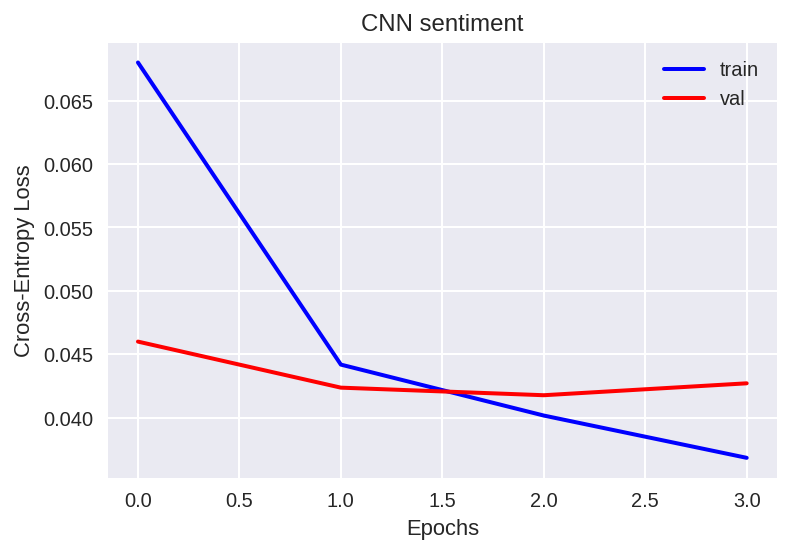

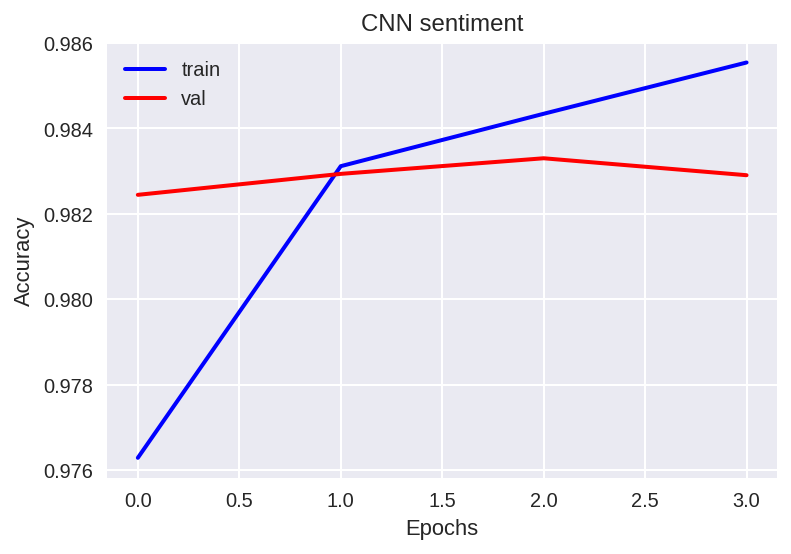

final score is 0.9841


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# pickle.dump({'strain': seq_train, 'stest': seq_test, 'fm':feature_matrix}, open('/content/gdrive/My Drive/comment/var.txt', 'wb'))
var = pickle.load(open('/content/gdrive/My Drive/comment/varibles.txt', 'rb'))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
x_train = var['xtrain']
x_test = var['xtest']
embedding_matrix = var['em']
y_train = var['ytrain']

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))



max_features = 100000
embed_size = 300
maxlen = 200

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

num_filters = 80
filter_sizes = [1,2,3]

inp = Input(shape=(maxlen, ))
x = Embedding(max_features, 
              embed_size,  
              input_length = maxlen,
              weights=[embedding_matrix],
              trainable=True)(inp)

x = SpatialDropout1D(0.5)(x)

x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)   #adding gru layer

conv_0 = Conv1D(num_filters, filter_sizes[0], 
                kernel_initializer=initializers.RandomNormal())(x)
conv_1 = Conv1D(num_filters, 
                filter_sizes[1], 
                kernel_initializer=initializers.RandomNormal())(x)
conv_2 = Conv1D(num_filters, 
                filter_sizes[2], 
                kernel_initializer=initializers.RandomNormal())(x)


ac_0 = PReLU()(conv_0)
ac_1 = PReLU()(conv_1)
ac_2 = PReLU()(conv_2)

# bn_0 = BatchNormalization()(ac_0)
# bn_1 = BatchNormalization()(ac_1)
# bn_2 = BatchNormalization()(ac_2)


maxpool_0 = MaxPooling1D(pool_size=(maxlen - filter_sizes[0] + 1))(ac_0)
maxpool_1 = MaxPooling1D(pool_size=(maxlen - filter_sizes[1] + 1))(ac_1)
maxpool_2 = MaxPooling1D(pool_size=(maxlen - filter_sizes[2] + 1))(ac_2)


z = Concatenate(axis=1)([maxpool_0,
                         maxpool_1,
                         maxpool_2])

z = BatchNormalization()(z)
z = Flatten()(z)
z = Dropout(0.3)(z)   #0.2 0.9834


fc = Dense(6, kernel_initializer=initializers.RandomNormal(), activation='sigmoid')(z)

model = Model(inp, fc)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])





# inp = Input(shape=(maxlen, ))

# x = Embedding(max_features, 
#               embed_size,  
#               input_length = maxlen,
#               weights=[embedding_matrix],
#               trainable=True)(inp)

# x = SpatialDropout1D(0.5)(x)
# x = Bidirectional(GRU(128, return_sequences=True))(x)

# avg_pool = GlobalAveragePooling1D()(x)
# max_pool = GlobalMaxPooling1D()(x)

# conc = Concatenate(axis=1)([avg_pool, max_pool])
# outp = Dense(6, activation="sigmoid")(conc)

# model = Model(inputs=inp, outputs=outp)
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])


model.summary()

batch_size = 512
epochs = 10

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, 
                                              test_size=0.1, 
                                              shuffle=True)

RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

early = EarlyStopping(monitor='val_acc', 
                      min_delta=0.01, 
                      patience=3, #4    0.9835
                      verbose=1)

callback_list = [RocAuc, early]

hist = model.fit(X_tra, y_tra, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 validation_data=(X_val, y_val),
                 callbacks=callback_list, 
                 verbose=1,
                 shuffle=True,
                 class_weight='balanced')


plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right') 
plt.show()

plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

y_pred = model.predict(x_test, batch_size=1024)
submission = pd.read_csv('sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
# submission.to_csv('CNN.csv', index=False)
test_labels = pd.read_csv('test_labels.csv')
real_test = test_labels[test_labels['toxic']>=0]
score = roc_auc_score(real_test[labels], submission.iloc[real_test.index][labels])
print('final score is {:.4f}'.format(score))

In [0]:
submission.to_csv('CNN.csv', index=False)

Architecture
First layer: concatenated fasttext and glove twitter embeddings. Fasttext vector is used by itself if there is no glove vector but not the other way around. Words without word vectors are replaced with a word vector for a word "something". Also, I added additional value that was set to 1 if a word was written in all capital letters and 0 otherwise.

Second layer: SpatialDropout1D(0.5)

Third layer: Bidirectional CuDNNLSTM with a kernel size 40. I found out that LSTM as a first layer works better than GRU.

Fourth layer: Bidirectional CuDNNGRU with a kernel size 40.

Fifth layer: A concatenation of the last state, maximum pool, average pool and two features: "Unique words rate" and "Rate of all-caps words"

Sixth layer: output dense layer.

Hyperparameters and preprocessing:
Batch size: 512. I found that bigger batch size makes results more stable.
Epochs: 15.
Sequence length: 900.
Optimizer: Adam with clipped gradient.
Preprocessing: Unidecode library (https://pypi.python.org/pypi/Unidecode) to convert text to ASCII first and after that filtering everything except letters and some punctuation.
Text normalization
I did a lot of work on fixing misspellings and I think it improved the score. I was only fixing misspellings that didn't have a fasttext vector. Things that I did:

Created a list of words that appear more often in toxic comments than in regular comments and words that appear more often in non-toxic comments. For every misspelled word I looked up if it has a word in the list with a small Levenshtein distance to it.
Fixed some misspellings with TextBlob dictionary.
Fixed misspellings by finding word vector neighborhoods. Fasttext tool can create vectors for out-of-dictionary words which is really nice. I trained my own fasttext vectors on Wikipedia comments corpus and used them to do this. I also used those vectors as embeddings but results were not as good as with regular fasttext vectors.